In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import gamma, gammainc
from scipy.fftpack import fftn, fftshift
from scipy.signal import find_peaks, peak_widths, peak_prominences
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [2]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP")

In [3]:
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Real Data Sets\First Tel-Aviv data', 'r')

In [4]:
x = f.get('x')
y = f.get('y')
t = f.get('t')
wamos = f.get('wamos')

x = np.array(x)
y = np.array(y)
t = np.array(t)
wamos = np.array(wamos)

In [5]:
dx = x[1] - x[0]
dy = y[1] - y[0]
dt = t[1] - t[0]
dk = 2*np.pi/(dx*min(wamos.shape[0], wamos.shape[1]))
dk

0.01269330365086785

In [6]:
eta = np.transpose(wamos, (1, 2, 0))
eta.shape

(132, 132, 366)

In [7]:
wamos[200,17,13]

1524.0

In [8]:
eta[17,13,200]

1524.0

In [9]:
Nx, Ny, Nt = eta.shape
    
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) 
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) 
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

In [10]:
dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

In [11]:
Norm = dKx * dKy * dW 

In [12]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

# 1.0) Taper Mask

In [13]:
import numpy as np

def tapering_function(n, a, L):
    if 0 <= n <= a * L / 2:
        return 0.5 * (1 + np.cos(np.pi * (2 * n / (a * L) - 1)))
    elif a * L / 2 <= n <= L * (1 - a / 2):
        return 1
    elif L * (1 - a / 2) <= n <= L:
        return 0.5 * (1 + np.cos(np.pi * (2 * n / (a * L) - 2 / a + 1)))
    else:
        return 0.0

def apply_tapering_3d(data, a):
    shape = data.shape
    tapering_3d = np.ones(shape)

    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                tapering_3d[i, j, k] = tapering_function(i, a, shape[0]) * tapering_function(j, a, shape[1]) * tapering_function(k, a, shape[2])

    tapered_data = data * tapering_3d

    return tapered_data

In [14]:
a_value = 0.1

In [15]:
tapered_eta = apply_tapering_3d(eta, a_value)

In [16]:
tapered_padded_eta = np.pad(tapered_eta, ((30,31), (30,31), (0, 0)), 'constant',  constant_values=0)

In [17]:
tapered_padded_eta.shape

(193, 193, 366)

In [18]:
# Taper Applied
Nx, Ny, Nt = tapered_padded_eta.shape
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values

In [19]:
# Taper Applied

# Get power spectra
Spectrum_raw = fftshift(fftn(tapered_padded_eta) / np.prod(tapered_padded_eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

# 1.1) HP Filter

In [13]:
I_0 = power_Spectrum
I_0.shape

(132, 132, 366)

In [14]:
w_cut = 0.03 * 2*np.pi
w_cut

0.18849555921538758

In [15]:
# Create a boolean mask based on the condition w >= w_cut
mask = (w >= w_cut)

In [16]:
I_1 = np.where(mask[ None, None,:], I_0, 0)
#The 

# 1.2) Lower k Limit

In [24]:
#mask_kx = (np.abs(Kx) > 0.07) 
#mask_ky = (np.abs(Ky) > 0.07) 
#mask_ky = (np.abs(Ky) > 0.07)

In [17]:
#I_2 = np.where(mask_kx[:, None, None], I_1, 0)
#I_3 = np.where(mask_ky[None, :, None], I_2, 0)
I_3 = I_1

In [19]:
# Your existing code
mask_kx = (np.abs(Kx) > 0.07)
mask_ky = (np.abs(Ky) > 0.07)

# Apply the masks to Kx and Ky
Kx_masked = np.where(mask_kx, Kx, 0)
Ky_masked = np.where(mask_ky, Ky, 0)

# Create a new 3D array with masked values of Kx and Ky in I_1
I_2 = I_1 * Kx_masked[:, None, None]
I_3 = I_2 * Ky_masked[None, :, None]

# 1.3) Energy Threshold

In [18]:
# Create a boolean mask based on the condition energy

P = np.max(I_3) / 2000
# Threshold

condition = ( np.max(I_3, axis=2) >= P )
# Is  maximum energy for each column vector along the ω axis > P

In [19]:
I_4 = np.where(condition[:, :, None], I_3, 0)

# 1.4) Peak Identification

In [20]:
def identification(kx, ky, ratio, prominence, distance):
    
    '''Scans for peaks and then sorts them by heights. 
    It keeps the peaks which are ratio times smaller than the next'''
    
    y = I_4[kx,ky,:]
    wj = np.zeros((I_4.shape[0], I_4.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
    
    else:
        peaks, stats = find_peaks(y, prominence=prominence, distance=distance)

        if len(peaks) == 1:
            wj[kx,ky] = w[peaks[0]]

        elif len(peaks) > 1:
            try_sort = list(set(y[peaks]))
            try_sort.sort()
            ind = np.where(y[peaks]==np.max(y[peaks]))
            thing = []

            for k in range(len(peaks)):
                if np.max(y[peaks]) >= ratio*try_sort[-2]:
                    #thing.append(w[peaks[ind]])
                    wj[kx,ky] = w[peaks[ind]]
                    
#        return {
#            "values": values,
#            "order": order,
#            "peaks": peaks,
#            "stats": stats,
#        }
    
    return wj 

In [23]:
l = 0

y = I_4[nonzero_indices[0][l], nonzero_indices[1][l],:]
peaks, stats = find_peaks(y, prominence=0.2*np.max(y), distance=10)

NameError: name 'nonzero_indices' is not defined

In [22]:
plt.scatter(w, I_4[nonzero_indices[0][l], nonzero_indices[1][l], :])

for i in w[peaks]:
    plt.axvline(i, color='red')

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)
plt.title("Should be counted")

NameError: name 'nonzero_indices' is not defined

In [21]:
wj_array = []

for kx in range(I_4.shape[0]):
    for ky in range(I_4.shape[1]):
        wj_array.append(identification(kx, ky, ratio=3, prominence=0.1*np.max(y), distance=10))

In [22]:
w0_2D = np.sum(wj_array, axis=0)
# gives the 2d array w0(kx,ky)

In [23]:
w0 = w0_2D[w0_2D != 0]

In [24]:
nonzero_indices = np.nonzero(w0_2D)
nonzero_indices

(array([51, 51, 53, 54, 54, 54, 54, 55, 55, 56, 56, 56, 57, 58, 58, 59, 59,
        59, 60, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63,
        64, 64, 64, 65, 65, 66, 66, 66, 66, 67, 67, 67, 67, 67, 68, 68, 68,
        68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70,
        70, 70, 70, 71, 71, 71, 72, 72, 72, 72, 73, 74, 75, 75, 76, 77, 78],
       dtype=int64),
 array([56, 57, 57, 54, 55, 57, 58, 54, 56, 53, 54, 55, 51, 50, 53, 53, 54,
        78, 49, 51, 53, 50, 52, 53, 46, 73, 80, 47, 49, 53, 69, 73, 74, 76,
        70, 72, 73, 72, 73, 54, 67, 72, 74, 67, 68, 69, 73, 74, 49, 53, 54,
        68, 69, 70, 72, 73, 80, 48, 54, 67, 68, 69, 74, 45, 47, 54, 67, 68,
        73, 75, 76, 49, 67, 74, 50, 65, 67, 73, 49, 48, 50, 80, 76, 75, 52],
       dtype=int64))

In [25]:
len(nonzero_indices[0])

85

In [26]:
kx_indices = nonzero_indices[0]
ky_indices = nonzero_indices[1]

In [27]:
kx_trip = Kx[kx_indices]
ky_trip = Ky[ky_indices]

In [28]:
%matplotlib widget

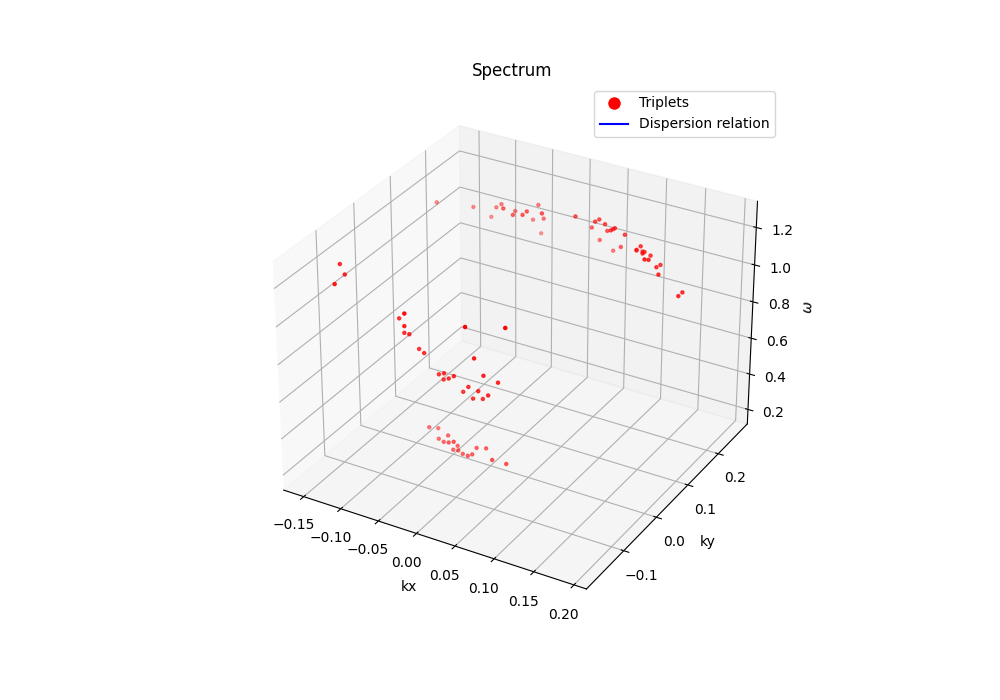

In [29]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(-kx_trip, -ky_trip, w0, color = "red", s = 5)
plt.title("Spectrum")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

# Create legend manually with a dot for 'Triplets'
legend_elements = [
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Triplets'),
    mlines.Line2D([0], [0], color='blue', label='Dispersion relation')
]

# Create legend
ax.legend(handles=legend_elements)
 
# show plot
plt.show()

# 1.5) Reverse Aliased Points

In [30]:
%matplotlib widget

In [31]:
Kx_2D, Ky_2D = np.meshgrid(Kx, Ky, indexing='ij')

# Create a mask to include aliased and non-aliased values
mask_aliased = (-Ky_2D > 0.05)
mask_nonaliased = (-Ky_2D < 0)

# Apply Masks
w0_2D_aliased = np.where(mask_aliased, w0_2D, 0)
w0_2D_nonaliased = np.where(mask_nonaliased, w0_2D, 0)

# Combine aliased and non-aliased components
w0_2D_combined = w0_2D_aliased + w0_2D_nonaliased

# combine Kx_2D and Ky_2D based on the masks
Kx_2D_combined = np.where(mask_aliased, Kx_2D, -Kx_2D)
Ky_2D_combined = np.where(mask_aliased, Ky_2D, -Ky_2D)


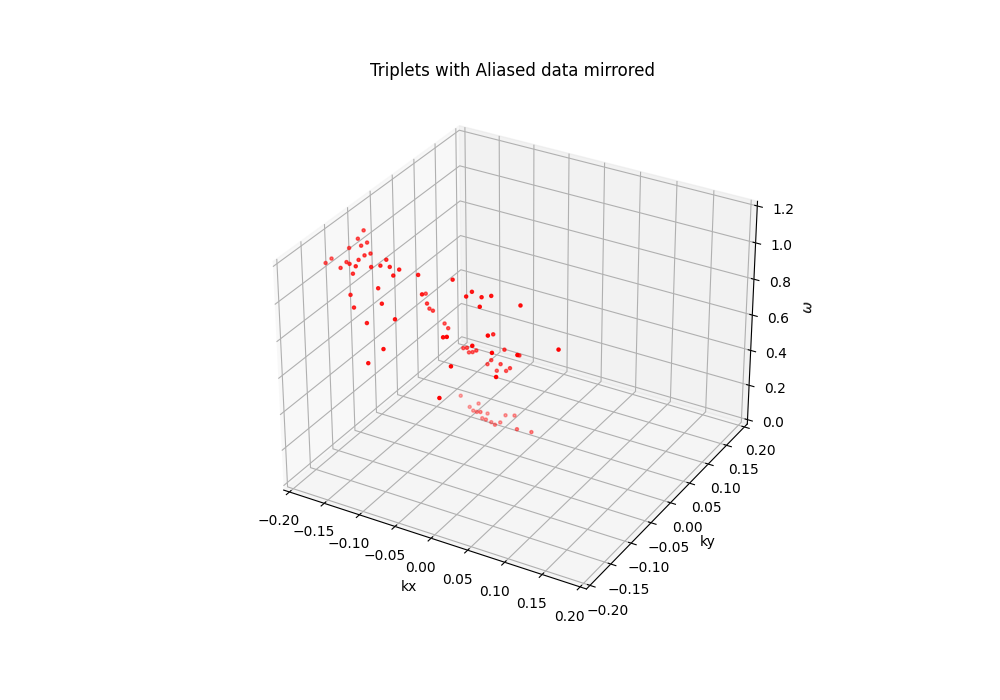

In [32]:
# Flatten the 2D arrays
x_flat = Kx_2D_combined.flatten()
y_flat = Ky_2D_combined.flatten()
z_flat = w0_2D_combined.flatten()

# Filter out points where z-data is 0
non_zero_indices = np.where(z_flat != 0)
x_filtered = x_flat[non_zero_indices]
y_filtered = y_flat[non_zero_indices]
z_filtered = z_flat[non_zero_indices]

# Create a 3D plot
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')
plt.title("Triplets with Aliased data mirrored")

# Scatter plot the points
ax.scatter(x_filtered, y_filtered, z_filtered, c='r', marker='o', s = 5)

In [33]:
kx_2D = Kx_2D_combined
ky_2D = Ky_2D_combined
w0_2D = w0_2D_combined

# 1.6) Remove Low Wavenumbers Data

In [34]:
# Create a mask based on Ky values
# Create a mask based on Ky values
mask = (np.abs(Kx) > 0.065)

#mask = (-Kx < -0.065)

In [35]:
# Apply the mask to the 2D array
w0_2D_filtered = np.where(mask[np.newaxis, :], w0_2D, 0)

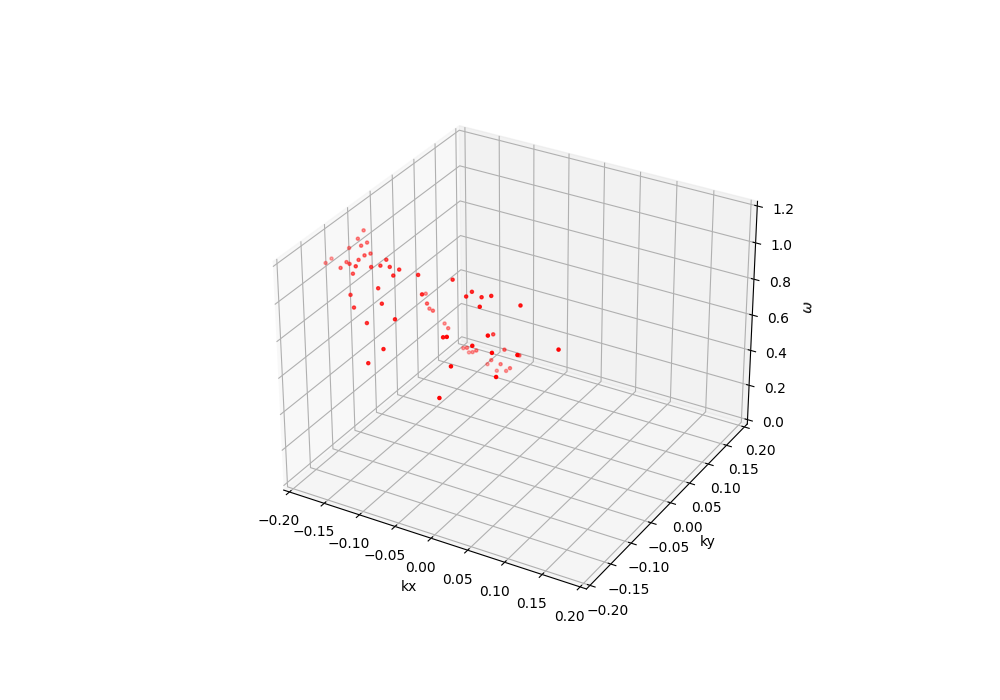

In [36]:
# Flatten the 2D arrays
x_flat = kx_2D.flatten()
y_flat = ky_2D.flatten()
z_flat = w0_2D_filtered.flatten()

# Filter out points where z-data is 0
non_zero_indices = np.where(z_flat != 0)
x_filtered = x_flat[non_zero_indices]
y_filtered = y_flat[non_zero_indices]
z_filtered = z_flat[non_zero_indices]

# Create a 3D plot
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

# Scatter plot the points
ax.scatter(x_filtered, y_filtered, z_filtered, c='r', marker='o', s = 5)

#ax.scatter3D(-kx_trip, -ky_trip, w0, color = "green", s = 5)

In [37]:
w0_2D = w0_2D_filtered

# 1.7) Convert to Polars

In [38]:
from scipy.stats import t

In [39]:
# kx_2D, ky_2D= np.meshgrid(kx_trip, ky_trip, indexing='ij')
kx_2D, ky_2D= np.meshgrid(Kx, Ky, indexing='ij')

In [40]:
K_2D = np.sqrt(kx_2D**2 + ky_2D**2)
theta_2D = np.arctan2(ky_2D, kx_2D)

# 1.8) Find Effective Current

In [41]:
%matplotlib inline

In [42]:
def sinusoidinal(x, a, b):
    return a*np.cos(x - b) 

In [43]:
def grubbs_test(x, y):
    """
    Grubb's test removes outlier in y axis and also removes the corresponding x value
    """

    # Gets mean and standard deviation of data
    mean_data = np.mean(y)
    std_data = np.std(y)

    # Calculate Grubbs test statistic
    z_scores = np.abs((y - mean_data) / std_data)
    max_z = np.max(z_scores)

    # Calculate critical value based on the t-distribution
    n = len(y)
    critical_value = t.ppf(0.975, n - 2) / np.sqrt(n)

    # Identify and removes any outlier
    outlier_index = np.argmax(z_scores)
    if max_z > critical_value:
        #print(f"Outlier detected at index {outlier_index}, value: {y[outlier_index]}")
        y = np.delete(y, outlier_index)
        x = np.delete(x, outlier_index)

        
    return x, y 

In [51]:
cut_k_array = np.arange(0.001, 0.35, 0.01)

U_array = []
Φ_array = []

for i in range(len(cut_k_array)):
    k_slice = cut_k_array[i]

    reso = 0.02
    # dk - either side of cut cylinder
    ind = np.where(((k_slice - reso) < K_2D ) & ( K_2D < (k_slice + reso)))
    
    #ind = np.where(np.round(K_2D, 2) == k_slice)
    
    # Slice at wavenumber cut_k - once k is within 0.01 it is counted as a slice
    w0_is_k = w0_2D[ind[0], ind[1]]
    theta_is_k = theta_2D[ind[0], ind[1]]
    
    # w and theta values along k_slice
    inds_where_w0_nonzero = np.where(w0_is_k != 0)
    
    if len(inds_where_w0_nonzero[0]) > 1:
        # How many nonzero w0 theres needs to be to be counted (increased numbers, increases accuracy)
        nonzero_theta_at_k = theta_is_k[inds_where_w0_nonzero]
        nonzero_w0_at_k = w0_is_k[inds_where_w0_nonzero]
        
        x_theta = nonzero_theta_at_k
        y_theta = (nonzero_w0_at_k - np.sqrt(9.81 * k_slice)) / k_slice
        
        # Preform Grubbs test to remove outliers
        x_theta, y_theta = grubbs_test(x_theta, y_theta)
        
        # Fitting Cos onto points
        pars0 = (max(y_theta), 1)  # initial guess
        popt, pcov = curve_fit(sinusoidinal, x_theta, y_theta, absolute_sigma=True, p0=pars0)
        
        # U value
        U_opt = popt[0]
        U_opt_err = np.sqrt(pcov[0, 0])
        U_array.append(np.abs(U_opt))
        
        # Φ
        Φ_opt = popt[1]
        Φ_opt_err = np.sqrt(pcov[1, 1])
        
        if U_opt > 0:
            Φ_opt = np.pi - Φ_opt
        # Condition due to definition of direction of current 
        
        Φ_array.append(Φ_opt)
    else:
        # If no values in inds_where_w0_nonzero, append None or a placeholder value as needed
        U_array.append(None)
        Φ_array.append(None)

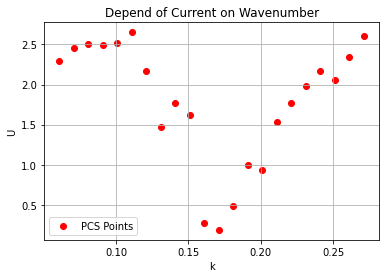

In [72]:
plt.scatter(cut_k_array, U_array, color = 'red', label = 'PCS Points')
#plt.plot(k, Uk[:,0], color = 'black', linestyle = '--',  label='Correct U')

plt.xlabel("k")
plt.ylabel("U")
plt.title("Depend of Current on Wavenumber")
plt.grid(True)
plt.legend()
#plt.xlim(0.15, 0.2)
#plt.ylim(0,2)

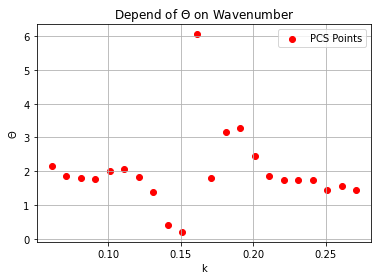

In [53]:
plt.scatter(cut_k_array,Φ_array, color = 'red', label = 'PCS Points')

plt.xlabel("k")
plt.ylabel("$\Theta$")
plt.title("Depend of $\Theta$ on Wavenumber")
plt.grid(True)
plt.legend()
#plt.ylim(-np.pi,np.pi)

# 1.9) Check at constant k

In [54]:
%matplotlib inline

In [55]:
k_slice = 0.18

reso = 0.02

inde = np.where(((k_slice - reso) < K_2D ) & ( K_2D < (k_slice + reso)))
#inde =  np.where( np.round(K_2D, 2) == k_slice)

w0_k_is_30 = w0_2D[inde[0],inde[1]]
# w values when k = 0.2

In [56]:
inds_where_w0_nonzero = np.where( w0_k_is_30 != 0)
# these indices where w0 is not equal to 0 when k = 0.2

In [57]:
theta_k_is_30 = theta_2D[inde[0],inde[1]]
# theta when k is 0.2

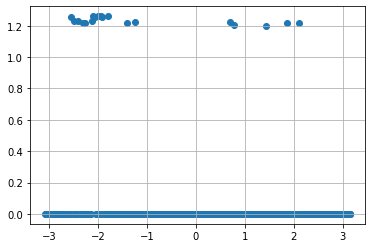

In [58]:
plt.scatter(theta_k_is_30, w0_k_is_30)
plt.grid(True)

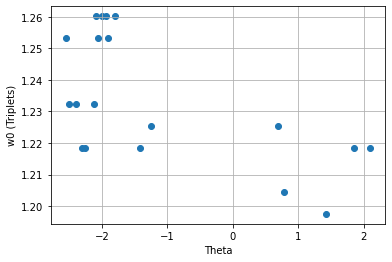

In [59]:
plt.scatter(theta_k_is_30[inds_where_w0_nonzero], w0_k_is_30[inds_where_w0_nonzero])

plt.xlabel("Theta")
plt.ylabel("w0 (Triplets)")
plt.grid(True)

In [60]:
x1 = theta_k_is_30[inds_where_w0_nonzero]
y = ( w0_k_is_30[inds_where_w0_nonzero] - np.sqrt(9.81*k_slice) )  / k_slice

In [61]:
def sinusoidinal(x, a, b):
    return a*np.cos(x - b)

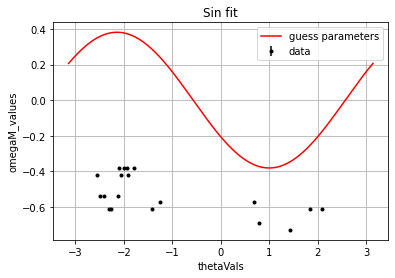

In [62]:
# plot the raw data
plt.errorbar(x1, y, yerr=0, fmt=".", color = 'black', label = 'data')
plt.grid(True)
plt.xlabel('thetaVals')
plt.ylabel('omegaM_values')


# initial guess
pars0 = ( max(y), 1)

# overlay exponential 

x = np.linspace(-np.pi, np.pi, 1000)

plt.plot(x, sinusoidinal(x,*pars0), color = 'red', label = 'guess parameters')

plt.legend();
plt.title("Sin fit");

Text(0, 0.5, 'omegaM_values')

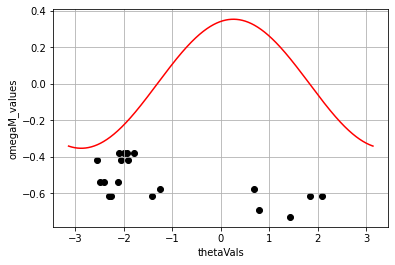

In [63]:
popt, pcov = curve_fit(sinusoidinal, x1, y, absolute_sigma=True, p0=pars0)

# extract best-fit parameter and its error
a_opt = popt[0]
a_opt_err = np.sqrt(pcov[0, 0])

# extract best-fit parameter and its error
b_opt = popt[1]
ab_opt_err = np.sqrt(pcov[1, 1])


# plot data
plt.scatter(x1, y, color = 'black', label = 'data')

# creating x interval to include in y fit
x = np.linspace(-np.pi, np.pi, 1000)
y_fit = sinusoidinal(x, *popt)
plt.plot(x, y_fit, color="red", label="best fit")

plt.grid(True)
plt.xlabel('thetaVals')
plt.ylabel('omegaM_values')
#plt.ylim(1.65, 2.08)

In [64]:
a_opt

0.3534658259668248

In [65]:
b_opt

0.26148226188087986

In [66]:
def grubbs_test(x, y):
    """
    Grubb's test removes outlier in y axis and also removes the corresponding x value
    """

    # Gets mean and standard deviation of data
    mean_data = np.mean(y)
    std_data = np.std(y)

    # Calculate Grubbs test statistic
    z_scores = np.abs((y - mean_data) / std_data)
    max_z = np.max(z_scores)

    # Calculate critical value based on the t-distribution
    n = len(y)
    critical_value = t.ppf(0.975, n - 2) / np.sqrt(n)

    # Identify and removes any outlier
    outlier_index = np.argmax(z_scores)
    if max_z > critical_value:
        #print(f"Outlier detected at index {outlier_index}, value: {y[outlier_index]}")
        y = np.delete(y, outlier_index)
        x = np.delete(x, outlier_index)

        
    return x, y 

In [67]:
x1, y = grubbs_test(x1, y)

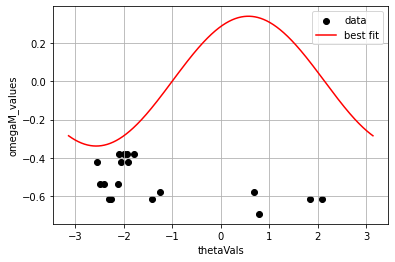

In [68]:
popt, pcov = curve_fit(sinusoidinal, x1, y, absolute_sigma=True, p0=pars0)

# extract best-fit parameter and its error
a_opt = popt[0]
a_opt_err = np.sqrt(pcov[0, 0])

# extract best-fit parameter and its error
b_opt = popt[1]
ab_opt_err = np.sqrt(pcov[1, 1])


# plot data
plt.scatter(x1, y, color = 'black', label = 'data')

# creating x interval to include in y fit
x = np.linspace(-np.pi, np.pi, 1000)
y_fit = sinusoidinal(x, *popt)
plt.plot(x, y_fit, color="red", label="best fit")

plt.grid(True)
plt.xlabel('thetaVals')
plt.ylabel('omegaM_values')
plt.legend();

In [69]:
a_opt

0.3376907198784072

In [70]:
b_opt

0.5702860345945464

# 1.10) Slice Spectrum at w

In [154]:
def plot_3d_as_2d(x, y, z, radial_filter=False, extent=None, ax=None, aspect='auto', colorbar=True, cb_label='', data_min=None, data_max=None, cmap='viridis'):
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    if radial_filter:
        filt = get_radial_filter(x, y)
    else:
        filt = 1
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4))
    sh = ax.imshow((filt*z).T, origin='lower', extent=(x[0]-dx//2, x[-1]+dx//2, y[0]-dy//2, y[-1]+dy//2 ), aspect=aspect, interpolation=None, vmin=data_min, vmax=data_max, cmap=cmap)
    if colorbar:
        bar = plt.colorbar(sh, ax=ax, label=cb_label)
    if not extent is None:
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
    return ax

In [155]:
def plot_kx_ky_spec(kx, ky, spec, radial_filter=False, extent=None, ax=None, colorbar=True, spec_min=None, spec_max=None, cmap='viridis'):    
    if not spec_min is None:
        data = np.where(spec<spec_min, spec_min, spec)
    if not spec_max is None:
        data = np.where(spec>spec_max, spec_max, spec)
    ax = plot_3d_as_2d(kx, ky, spec, radial_filter, extent, ax, aspect=1, colorbar=colorbar, data_min=spec_min, data_max=spec_max, cmap=cmap)
    ax.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
    ax.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
    return ax


In [156]:
def plot_w_slice(at_w, extent, ax=None, dB=None, vmin=None, save=False):
        '''
        plots the integrated kx-ky-spectrum and the integrated k-omega-spectrum
        '''
        if at_w > 0:
            i = np.argmin(np.abs(w[Nt//2:]-at_w))
            print(at_w, w[Nt//2+i], i) 
            plotting_interface.plot_kx_ky_spec(Kx, Ky, power_Spectrum[:,:,Nt//2+i], extent=extent, ax=ax)
        else:
            i = np.argmin(np.abs(w[:Nt//2]-at_w))
            print(at_w, w[i], i) 
            plotting_interface.plot_kx_ky_spec(Kx, Ky, power_Spectrum[:,:,Nt//2+i], extent=extent, ax=ax)

1.2 1.1975056878710821 172


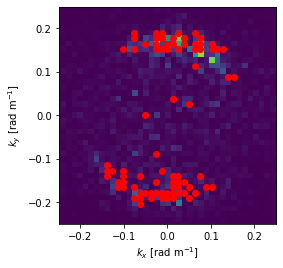

In [214]:
plot_w_slice(at_w=1.2, extent = [-0.25,0.25, -0.25, 0.25], ax=None, dB=None, vmin=None, save=False)

plt.scatter(Kx[kx_ind], Ky[ky_ind], color = 'red')

In [199]:
at_w = 1.2
i = np.argmin(np.abs(w[:Nt//2]-at_w))

In [213]:
# Flatten the array and get the indices of the sorted values
flat_indices = np.argsort(power_Spectrum[:,:,Nt//2+i].flatten())[::-1]

# Take the top 20 indices
top_20_indices = flat_indices[:80]

# Convert flat indices to 2D indices
top_20_indices_2d = np.unravel_index(top_20_indices, power_Spectrum[:,:,Nt//2+i].shape)

kx_ind, ky_ind = top_20_indices_2d[0], top_20_indices_2d[1]

In [201]:
kx_ind

array([67, 68, 68, 64, 68, 65, 65, 64, 67, 64], dtype=int64)

In [202]:
Ky[69]

0.03807991095260355

(-0.25, 0.25)

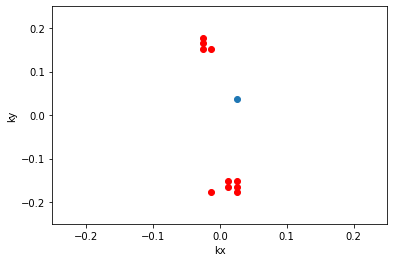

In [203]:
plt.scatter(Kx[kx_ind], Ky[ky_ind], color = 'red')

plt.scatter(Kx[68], Ky[69])

plt.xlabel("kx")
plt.ylabel("ky")

plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)

In [125]:
Nx

132

In [127]:
dW

0.006962242371343352

In [134]:
Nt0 = 366

In [135]:
def get_anti_aliased_spec3d():
        '''
        
        '''       
        grid = [Kx, Ky, w]
        kx0, ky0, w0 = grid
        Nt = 2*Nt0-2
        Nx = len(kx0)
        Ny = len(ky0)        
        theta_mean = self.get_peak_dir()
        dtheta_max = 70*np.pi/180
        spectrum_extended = np.zeros((Nx, Ny, Nt))
        w_extended = dW * np.arange(-Nt//2, Nt//2) 
        interval = Nt//2
        kx_mesh, ky_mesh, w_mesh = np.meshgrid(kx0, ky0, w0, indexing='ij')
        th = np.arctan2(ky_mesh, kx_mesh)
        mask_lower = np.where(np.abs(th - (theta_mean - np.pi))<= dtheta_max, 1, 0)
        
        # bin ich eigentlich in der richtigen Richtung? Habe ich das richtig simuliert? hmmm muss angepasst werden, aber wo?
        spectrum_extended[:,:,Nt//2:Nt//2+interval] = np.where(mask_lower[:,:,interval:], self.spectrum[:,:,interval:], 0).copy()
        upper_spec = np.where(mask_lower[:-1,:-1,:interval-1], self.spectrum[:-1,:-1, :interval-1], 0)
        spectrum_extended[1:,1:,Nt//2+interval:] = upper_spec.copy()

        # mirror:
        spectrum_extended[1:,1:,1:Nt//2] = np.flip(spectrum_extended[1:,1:,Nt//2+1:]).copy()
        grid = [kx0, ky0, w_extended]
        return spectrum_extended, grid  

In [136]:
spec3d_anti_aliased = get_anti_aliased_spec3d()

NameError: name 'self' is not defined